In [41]:
from net import skip
from net.losses import ExclusionLoss, plot_image_grid, StdLoss, CannyDiceLoss
from net.noise import get_noise
from utils.image_io import *
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from collections import namedtuple
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
class AlbedoDataset(Dataset):
    def __init__(self, image, albedo):
        self.image = image
        self.albedo = albedo

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        image = prepare_image(self.image[index])
        dest = prepare_image(self.albedo[index])
        mask = (image > 0.01).astype(np.float32)
        return image, dest, mask

In [94]:
class PreTrain(object):
    def __init__(self, dataset, save_path, num_iter=25):
        self.dataset = dataset

        self.num_iter = num_iter

        self.psnrs = []

        self.loss_function = None

        self.parameters = None
        self.learning_rate = 0.001
        # self.learning_rate = 0.01
        self.input_depth = 3

        self.net_inputs = None

        self.net = None

        self.total_loss = None
        self.out = None

        self.current_result = None
        self.best_result = None

        self.train_loader = None
        self.test_loader = None

        self.optimizer = None

        self.save_path = save_path
        self.loss_curve = []
        self.test_results = []
        self.test_losses = []

        self.ssim_loss = None

        self.fig = None
        self.axs = None

        self.train_loss = None

        torch.manual_seed(42)

        self._init_all()

    def _init_all(self):
        self._init_nets()
        self._init_dataset()
        self._init_parameters()
        self._init_losses()

    def _init_plot(self, n=3):
        self.fig, self.axs = plt.subplots(1, n, figsize=(5*n, 5))
        if n == 1:  # If there's only one image, put it in a list
            self.axs = [self.axs]

    def _init_dataset(self):

        train_size = 600
        test_size = len(self.dataset) - train_size
        self.train_dataset, self.test_dataset = random_split(self.dataset, [train_size, test_size])
        self.train_loader = DataLoader(self.train_dataset, batch_size=1, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)

    def _init_parameters(self):
        self.parameters = [p for p in self.net.parameters()]
        self.optimizer = torch.optim.Adam(self.parameters, lr=self.learning_rate)

    def _init_nets(self):
        data_type = torch.cuda.FloatTensor
        pad = 'reflection'
        net = skip(
            3, 3,
            num_channels_down=[32, 64, 128, 256, 512],
            num_channels_up=[32, 64, 128, 256, 512],
            num_channels_skip=[8, 8, 8, 8, 8],
            upsample_mode='bilinear',
            filter_size_down=5,
            filter_size_up=5,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

        self.net = net.type(data_type)


    def _init_losses(self):
        data_type = torch.cuda.FloatTensor
        self.ssim_loss = SSIM(win_size=5, win_sigma=0.8, data_range=1, size_average=True, channel=3)
        self.l1_loss = nn.L1Loss().type(data_type)
        self.l2_loss = nn.MSELoss().type(data_type)
    
    

    def save_checkpoint(self, epoch, checkpoint_path):

        checkpoint = {
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': epoch,
            'loss_record': self.loss_curve
        }

        torch.save(checkpoint, checkpoint_path)

    def optimize(self):
        
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = True
        
        for j in range(self.num_iter):
            self.optimizer.zero_grad()
            self._optimization_closure(j)
            self.optimizer.step()
            
            # if j % 1 == 0:
            self.save_checkpoint(j, self.save_path+'_'+str(j)+'_'+str(self.total_loss.item())+'.pth')
        
        self.save_checkpoint(self.num_iter, self.save_path+'_final'+'_'+str(self.total_loss.item())+'.pth')

    def imshow_grid(self, ims, titles=None):
        """Display a list of images as a grid."""
        self._init_plot()
        for i in range(3):
            img = ims[i].detach().cpu().numpy()[0].transpose((1, 2, 0))
            # Optional: Un-normalize the image if you used normalization during preprocessing
            # e.g., mean = np.array([0.485, 0.456, 0.406]) and std = np.array([0.229, 0.224, 0.225])
            # img = std * img + mean
            img = np.clip(img, 0, 1)
            
            self.axs[i].imshow(img)
            self.axs[i].axis('off')
            if titles:
               self.axs[i].set_title(titles[i])

        plt.show()

    def _optimization_closure(self, step):
        
        data_type = torch.cuda.FloatTensor
        show_image, show_dest, show_out = None, None, None
        for image, dest, mask in tqdm(self.train_loader):
            self.out = self.net(image.type(data_type))
            mask = mask.type(data_type)
            self.total_loss = self.l2_loss(mask * self.out, mask * dest.type(data_type))
            # self.total_loss = (1 - self.ssim_loss(mask * self.out, mask * dest.type(data_type)))
            # self.total_loss += 10 * torch.mean((1 - mask) * self.out)
            self.total_loss.backward()
            show_image, show_dest, show_out = image, dest, self.out

        self.imshow_grid([show_image, show_dest, show_out])
        self.loss_curve.append(self.total_loss.item())
        print('Iteration {:5d}    Loss {:5f}  '.format(
            step, self.total_loss.item()), '\r', end='')

    def load_checkpoint(self, checkpoint_path):
        
        checkpoint = torch.load(checkpoint_path)
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_loss = checkpoint['loss_record']
        return checkpoint['epoch']

    def test(self, saved_model=None):

        data_type = torch.cuda.FloatTensor
        if saved_model:
            self.net.load_state_dict(saved_model)
        self.net.eval()
        with torch.no_grad():
            for image, dest, mask in tqdm(self.test_loader):
                mask = mask.type(data_type)
                self.out = self.net(image.type(data_type)) * mask
                loss = 1 - self.l2_loss(mask * self.out, mask * dest.type(data_type))
                self.test_losses.append(loss.item())

                self.test_results.append([image, self.out, dest])
        
        print(np.mean(self.test_losses))   


In [44]:
def get_image_paths(dirpath):
    dirlist = os.listdir(dirpath)
    images = []
    for name in dirlist:
        if name.endswith('.png'):
            images.append(os.path.join(dirpath, name))
    images.sort()
    return images

In [45]:
albedo_dirpath = 'C:\\Users\\lucien\\Github\\data\\albedo'
image_dirpath = 'C:\\Users\\lucien\\Github\\data\\hybrid'
albedos = get_image_paths(albedo_dirpath)
images = get_image_paths(image_dirpath)
for a, i in zip(albedos, images):
    assert a.split('\\')[-1] == i.split('\\')[-1]

In [46]:
albedo_dataset = AlbedoDataset(image=images, albedo=albedos)

In [47]:
# torch.manual_seed(42)

# train_size = int(0.8 * len(albedo_dataset))
# test_size = len(albedo_dataset) - train_size
# train_dataset, test_dataset = random_split(albedo_dataset, [train_size, test_size])
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [88]:
t = PreTrain(albedo_dataset, 'C:\\Users\\lucien\\Github\\CGVI-Project\\results\\albedo_pretrain', 50)

In [91]:
print(t.test_dataset.indices)

[176, 897, 267, 548, 708, 509, 330, 192, 584, 609, 17, 746, 506, 354, 778, 899, 25, 57, 503, 28, 712, 879, 171, 655, 27, 268, 547, 734, 510, 204, 777, 131, 416, 317, 108, 48, 846, 7, 468, 374, 198, 79, 349, 649, 9, 594, 195, 689, 929, 189, 381, 216, 224, 299, 20, 892, 175, 562, 617, 647, 740, 648, 727, 517, 294, 722, 217, 461, 69, 873, 833, 918, 58, 439, 553, 820, 301, 613, 687, 911, 888, 614, 392, 723, 316, 887, 568, 291, 550, 541, 235, 0, 632, 469, 383, 605, 213, 455, 522, 13, 250, 359, 749, 253, 109, 497, 333, 526, 872, 825, 765, 221, 488, 399, 744, 545, 792, 173, 580, 868, 285, 266, 414, 857, 402, 397, 417, 1, 759, 100, 24, 309, 218, 236, 91, 321, 591, 51, 346, 254, 231, 666, 717, 837, 902, 200, 798, 172, 642, 120, 428, 262, 700, 659, 805, 878, 193, 663, 375, 464, 680, 665, 89, 923, 432, 656, 737, 625, 524, 329, 92, 358, 188, 66, 269, 74, 415, 515, 293, 331, 757, 465, 817, 925, 166, 821, 394, 345, 870, 182, 413, 481, 372, 295, 809, 479, 667, 78, 90, 183, 921, 361, 134, 379, 471, 92

In [69]:
t.optimize()

  2%|▏         | 14/600 [00:01<00:59,  9.90it/s]


KeyboardInterrupt: 

In [75]:
t.load_checkpoint("C:\\Users\\lucien\\Github\\CGVI-Project\\results\\albedo_pretrain_final_0.01948373392224312.pth")

50

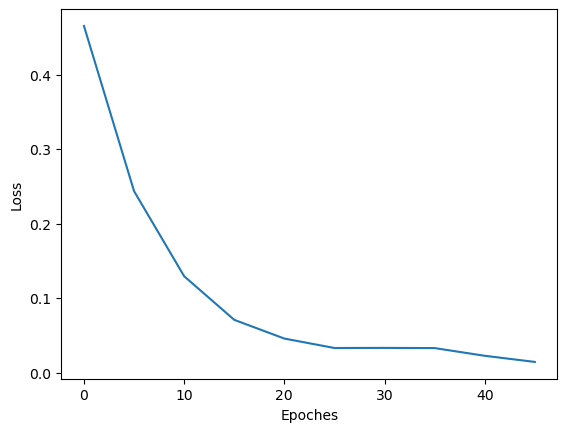

In [81]:
tx = range(50)[::5]
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.plot(tx, t.train_loss[::5])

In [50]:
t.test()

100%|██████████| 330/330 [00:22<00:00, 14.91it/s]

0.9977600708152309


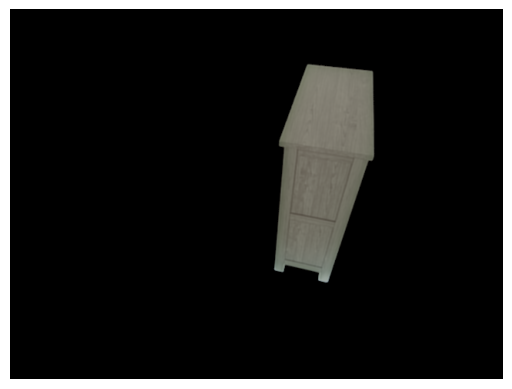

tensor(0.6589, device='cuda:0') tensor(0., device='cuda:0')


In [52]:


# Create a dummy tensor for demonstration purposes
# Replace this with your tensor if you have one
tensor = t.test_results[300][1]

# Process tensor for visualization
image = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step


# Display image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

print(torch.max(tensor), torch.min(tensor))

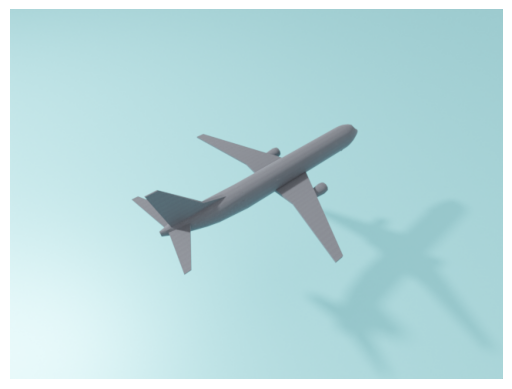

In [136]:


# Create a dummy tensor for demonstration purposes
# Replace this with your tensor if you have one
tensor = t.test_results[2000][0]

# Process tensor for visualization
image = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

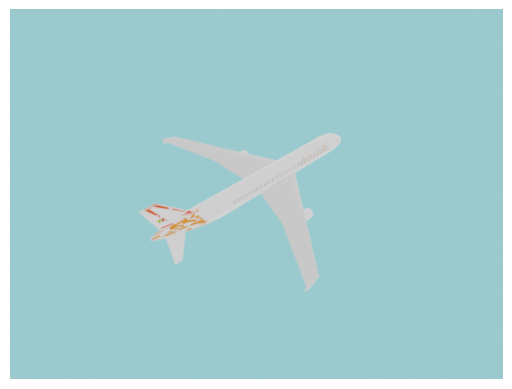

In [134]:


# Create a dummy tensor for demonstration purposes
# Replace this with your tensor if you have one
tensor = t.test_results[10][2]

# Process tensor for visualization
image = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

In [53]:
shading_dirpath = 'C:\\Users\\lucien\\Github\\data\\shading'
image_dirpath = 'C:\\Users\\lucien\\Github\\data\\hybrid'
shadings = get_image_paths(shading_dirpath)
images = get_image_paths(image_dirpath)
for a, i in zip(shadings, images):
    assert a.split('\\')[-1] == i.split('\\')[-1]

shading_dataset = AlbedoDataset(image=images, albedo=shadings)
s = PreTrain(shading_dataset, 'C:\\Users\\lucien\\Github\\CGVI-Project\\results\\shading_pretrain', 50)

100%|██████████| 600/600 [00:50<00:00, 11.92it/s]


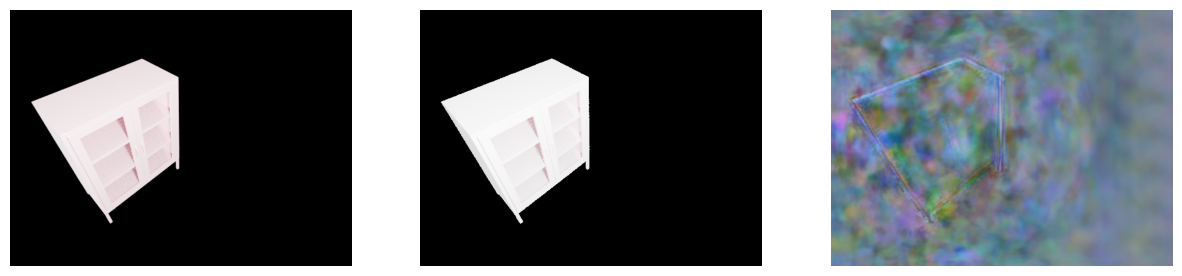

100%|██████████| 600/600 [00:50<00:00, 11.80it/s]


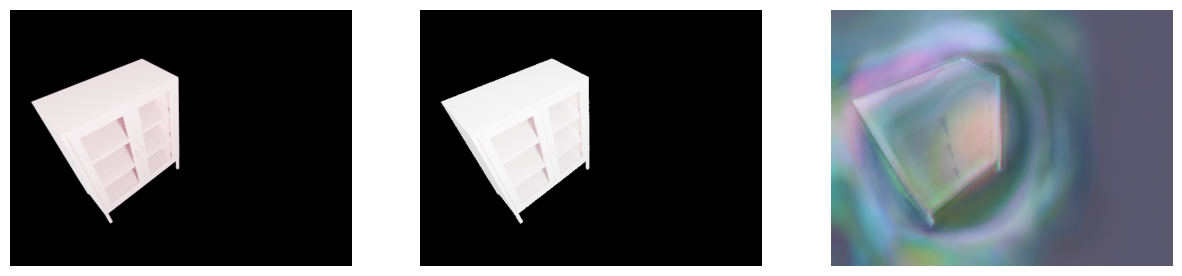

100%|██████████| 600/600 [00:50<00:00, 11.89it/s]


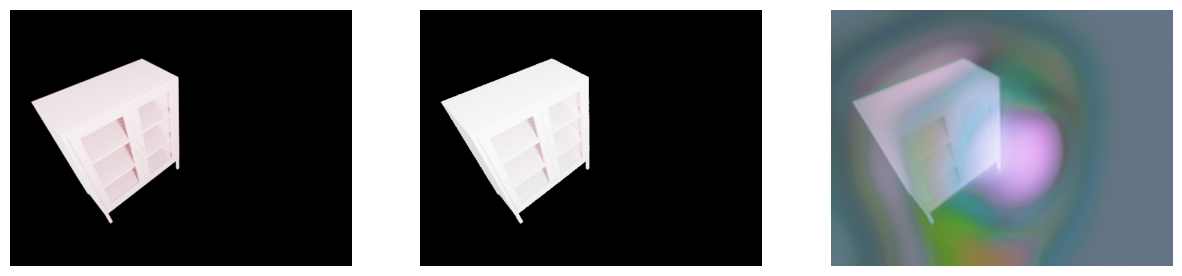

100%|██████████| 600/600 [00:50<00:00, 11.84it/s]


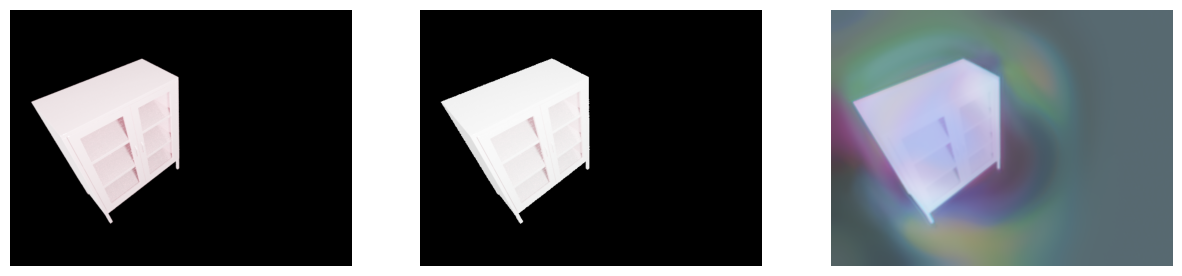

100%|██████████| 600/600 [00:51<00:00, 11.72it/s]


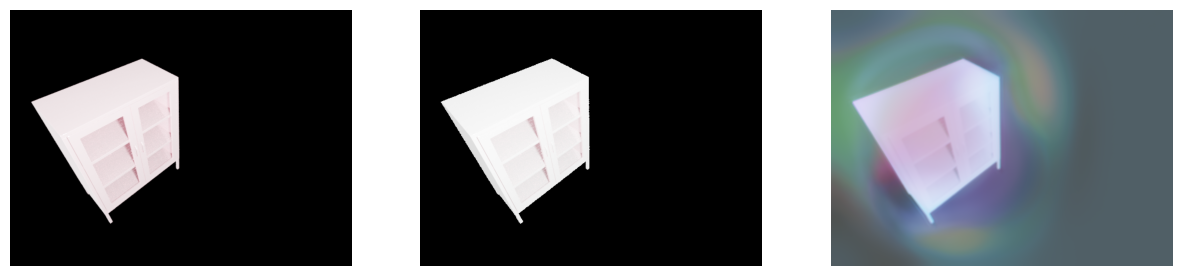

100%|██████████| 600/600 [01:02<00:00,  9.66it/s]


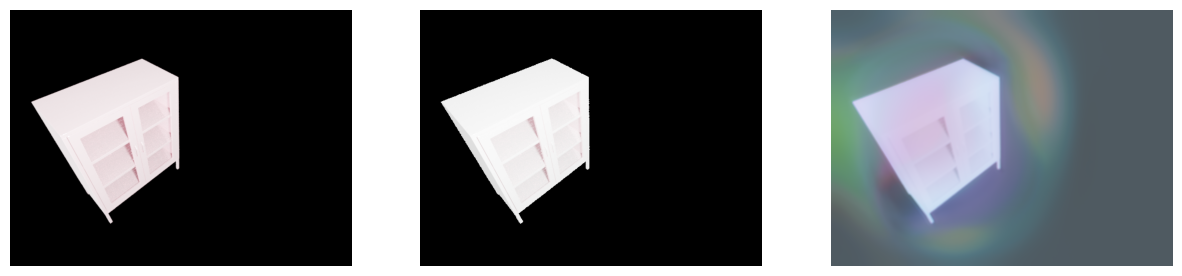

100%|██████████| 600/600 [00:50<00:00, 11.88it/s]


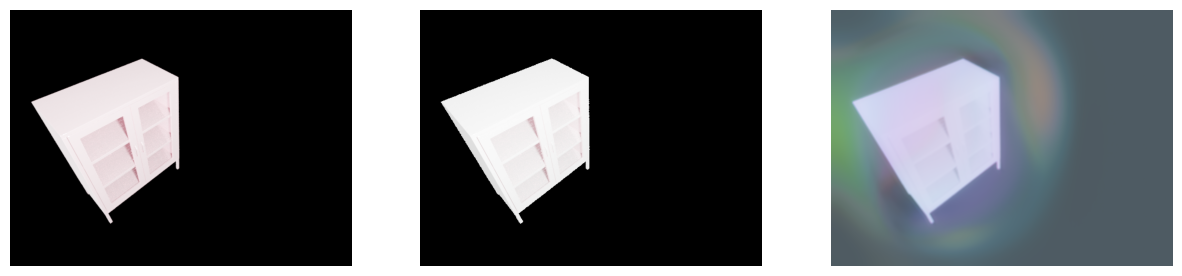

100%|██████████| 600/600 [00:50<00:00, 11.87it/s]


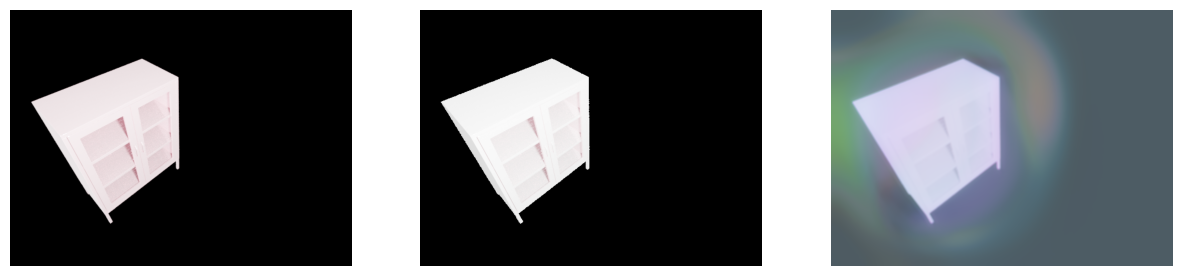

100%|██████████| 600/600 [00:50<00:00, 11.92it/s]


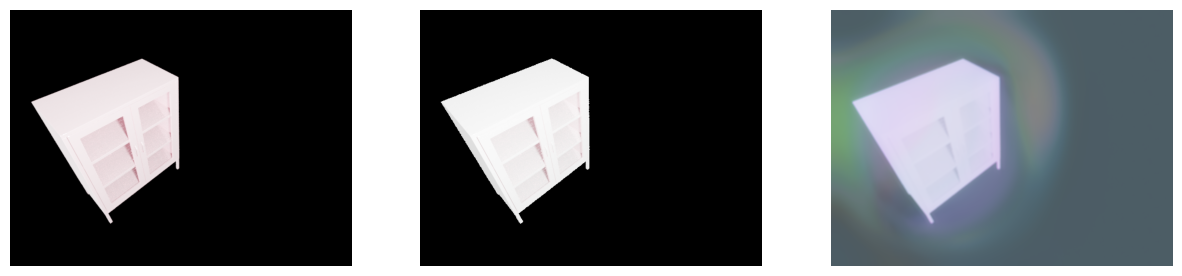

100%|██████████| 600/600 [00:51<00:00, 11.72it/s]


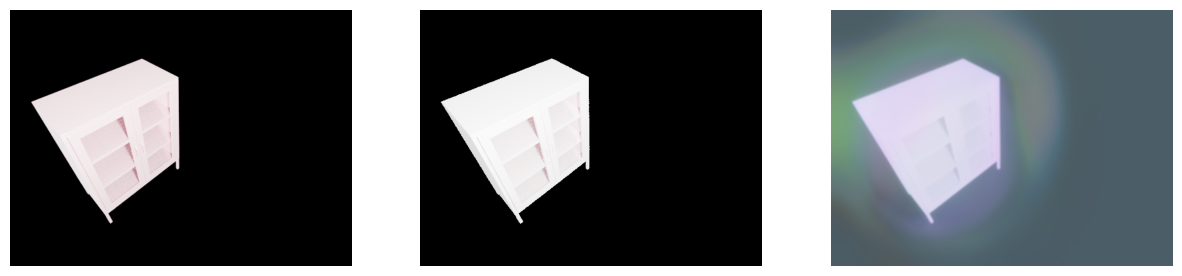

100%|██████████| 600/600 [00:50<00:00, 11.92it/s]


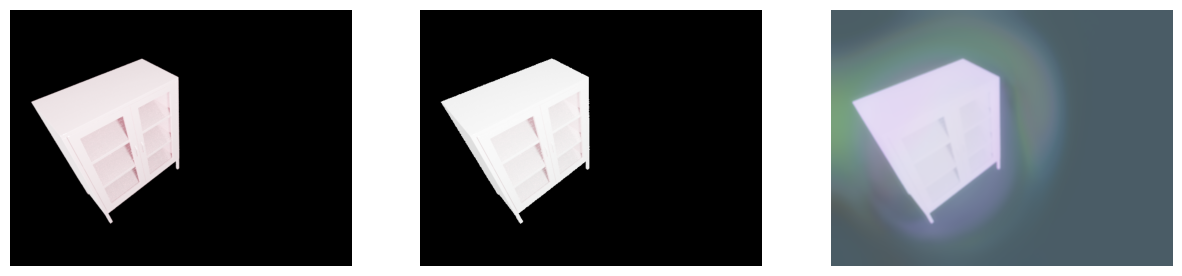

  4%|▍         | 25/600 [00:02<00:51, 11.21it/s]


KeyboardInterrupt: 

In [95]:
shading_dirpath = 'C:\\Users\\lucien\\Github\\data\\shading'
image_dirpath = 'C:\\Users\\lucien\\Github\\data\\hybrid'
shadings = get_image_paths(shading_dirpath)
images = get_image_paths(image_dirpath)
for a, i in zip(shadings, images):
    assert a.split('\\')[-1] == i.split('\\')[-1]

shading_dataset = AlbedoDataset(image=images, albedo=shadings)
s = PreTrain(shading_dataset, 'C:\\Users\\lucien\\Github\\CGVI-Project\\results\\shading_pretrain', 50)
s.optimize()

In [83]:
s.load_checkpoint("C:\\Users\\lucien\\Github\\CGVI-Project\\results\\shading_pretrain_10_0.0009461530717089772.pth")

10

In [55]:
s.test()

100%|██████████| 330/330 [00:20<00:00, 16.48it/s]

0.9983041452639031


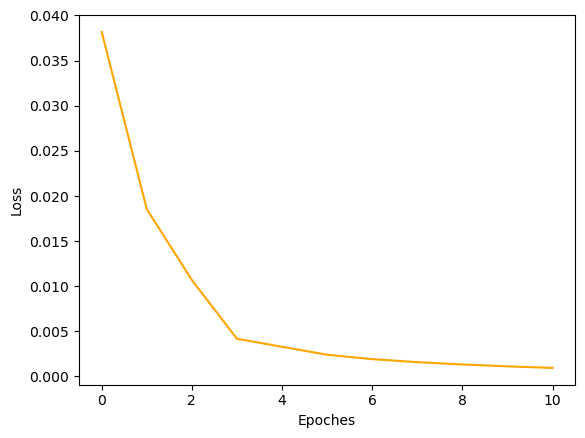

In [86]:
tx = range(11)
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.plot(tx, s.train_loss, color='orange')

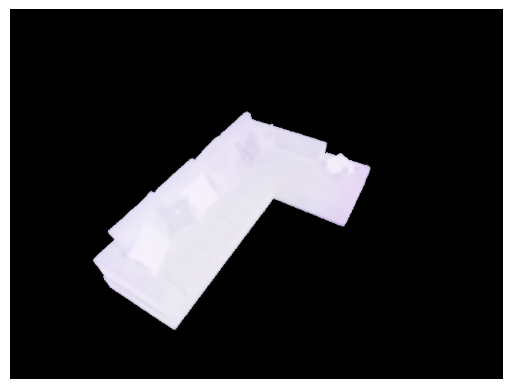

In [66]:
# Create a dummy tensor for demonstration purposes
# Replace this with your tensor if you have one
tensor = s.test_results[3][1]

# Process tensor for visualization
image = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

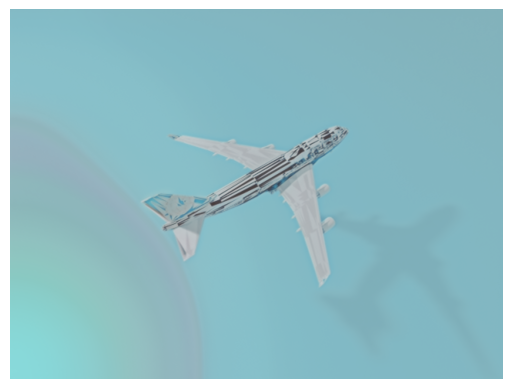

In [19]:
# Create a dummy tensor for demonstration purposes
# Replace this with your tensor if you have one
tensor = s.test_results[0][1] * t.test_results[0][1]

# Process tensor for visualization
image = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

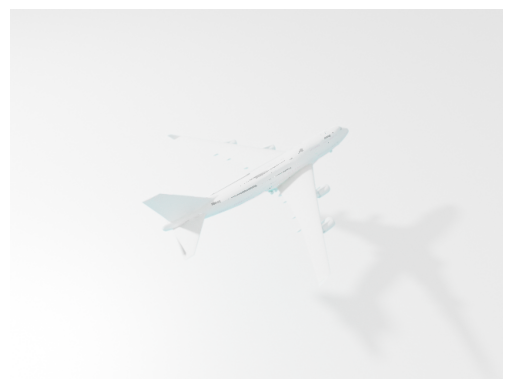

In [17]:
# Create a dummy tensor for demonstration purposes
# Replace this with your tensor if you have one
tensor = s.test_results[0][2]

# Process tensor for visualization
image = tensor.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()